# Exploratory Data Analysis (EDA) of Spotify Data Over Time
## Ange Olson

Since April of 2016, I've made (almost) monthly playlists on Spotify consisting of the songs I enjoyed listening to that month. I created them as the month went on, meaning they've got a couple of cool characteristics:

* They can be used to see which artist/genres I was listening to together at any given time
* They provide point-in-time stats rather than the short-term, medium-term, and long-term song histories directly available from the API 
* They can more accurately be used to determine songs I particularly liked than looking at the songs I listened to frequently, and compared to the songs I listened to that didn't end up on a playlist (read: content-based recommendation system)

I've gone through and pulled the data from all the playlists, grabbing the typical metadata on each song (see the [Spotify Documentation on audio features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) for a full list and descriptions) including artist name, genre, release year, valence, tempo, key, etc. I was able to use the name of the playlist itself, dated almost uniformly throughout the past 6 years, to grab the month and year I listened to the song. 

In the analysis below, I mostly focus on either month trends for all years, or trends over the past 6 years rather than analyzing the data as a whole. 

# Section I: Basic Info 
##### How many observations do I have? How many months am I missing? How balanced is the dataset? 

Before getting started, I want to see how many observations of months I have (for lookng at trends across a year) and how many observations I have per month. In short, I don't have a perfectly balanced dataset, with x songs per month and y observations of each month. It's good to know going in to know which months I have fewer data points on, what dates my time series is skipping over, and how I'll need to handle some of the stats I plan to look at.

In [17]:
# import packages, data, set theme 

# packages
from matplotlib import markers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 
import statistics
import plotly.express as px
import statsmodels 
import plotly.offline as py


# graphing
sns.set_theme(style="whitegrid", palette="Paired")
py.init_notebook_mode(connected=True)

# data
df = pd.read_csv("Time Series Data/time_series_data_clean.csv")

In [18]:
# define pivot table function and use to create main dataframes

# get vals that need to be averaged
mean_vals = "danceability", "energy", "loudness", "speechiness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "track_pop", "artist_pop", "release_year"

# get vals for mode
mode_vals = "key", "mode", "time_signature", "artist_genre", "artist"

def getPivot(mean_vals, mode_vals, index):
    
    # define pivot table of means
    table_means = pd.pivot_table(df, index = index, values = mean_vals, aggfunc=np.mean)
    
    # define pivot table of modes
    table_modes = pd.pivot_table(df, index = index, values = mode_vals, aggfunc=statistics.mode)

    pivot_df = table_means.join(table_modes, on=index)
    pivot_df.reset_index(inplace=True)
    pivot_df = pivot_df.rename(columns = {'index': index})

    return pivot_df

# create pivot table by date
# get index val
index = "playlist_date"

datePivot = getPivot(mean_vals=mean_vals, mode_vals=mode_vals, index=index)

datePivot["playlist_date"] = pd.to_datetime(datePivot.playlist_date)

# create pivot table by month
# get index val
index2 = "playlist_month"

monthPivot = getPivot(mean_vals=mean_vals, mode_vals=mode_vals, index=index2)

The months with the lowest number of observations are June and August (2), but all months have at least one observation.

In [19]:
month_counts = df.groupby('playlist_month')['playlist_date'].nunique()
print(month_counts)

playlist_month
1     4
2     4
3     3
4     6
5     4
6     2
7     4
8     2
9     3
10    3
11    3
12    3
Name: playlist_date, dtype: int64


In [20]:
# Calculate artist variance, genre variance in playlists, total number of tracks to normalize by date
dateArtVariance = df.groupby('playlist_date')['artist'].nunique()
dateGenVariance = df.groupby('playlist_date')['artist_genre'].nunique()
dateTrackCount = df.groupby('playlist_date')['track_name'].nunique()

# normalization: 
# artist: if 1, artist to track ratio is 1:1 (i.e. each artist has one track). The lower the number, the more times you're listening to songs by the same artist. 
# genre: if 1, every song has a different genre. The lower the number, the more similar in genre each playlist is. 

dateArtVarNorm = dateArtVariance/dateTrackCount
dateGenVarNorm = dateGenVariance/dateTrackCount

In [21]:
# Calculate artist variance, genre variance in playlists, total number of tracks to normalize by month
monthArtVariance = df.groupby('playlist_month')['artist'].nunique()
monthGenVariance = df.groupby('playlist_month')['artist_genre'].nunique()
monthTrackCount = df.groupby('playlist_month')['track_name'].nunique()

# normalization: if 1, artist to track ratio is 1:1 (i.e. each artist has one track). The lower the number, the more times you're listening to songs by the same artist. 

monthArtVarNorm = monthArtVariance/monthTrackCount
monthGenVarNorm = monthGenVariance/monthTrackCount

The total number of tracks also varies by month, also in the same trend as above.

In [22]:
print(monthTrackCount)

playlist_month
1     126
2     132
3     126
4     171
5     133
6      28
7     119
8      63
9      83
10     69
11    132
12     64
Name: track_name, dtype: int64


The average number of tracks varies less; June still has the lowest average number of tracks per month, while November and March have the two highest.

In [23]:
print(monthTrackCount/month_counts)

playlist_month
1     31.500000
2     33.000000
3     42.000000
4     28.500000
5     33.250000
6     14.000000
7     29.750000
8     31.500000
9     27.666667
10    23.000000
11    44.000000
12    21.333333
dtype: float64


The number of tracks per point in time predictably changes, but recently the range of playlist size seems to have leveleled out some, with playlists looking shorter on average. 

playlist_date
2016-04-01    23
2016-07-01    76
2017-04-01    48
2017-07-01     9
2017-09-01    45
2017-11-01    94
2018-01-01    43
2018-02-01    29
2018-03-01    42
2018-04-01    17
2018-05-01     4
2018-10-01    35
2018-11-01    23
2018-12-01    18
2019-02-01    22
2019-09-01    21
2020-01-01    27
2020-04-01    48
2020-05-01    70
2020-07-01    14
2020-08-01    45
2020-10-01     7
2020-12-01    15
2021-01-01    14
2021-02-01    53
2021-03-01    52
2021-04-01    13
2021-05-01    36
2021-06-01    13
2021-07-01    21
2021-08-01    18
2021-09-01    17
2021-10-01    27
2021-11-01    16
2021-12-01    31
2022-01-01    44
2022-02-01    28
2022-03-01    32
2022-04-01    23
2022-05-01    23
2022-06-01    15
Name: track_name, dtype: int64


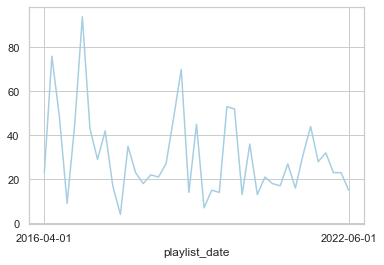

In [24]:
print(dateTrackCount)
sns.lineplot(y=dateTrackCount.values, x=dateTrackCount.index)
plt.xticks(['2016-04-01', '2022-06-01'])
plt.show()

Because of this, for any analysis related to top artists, or top genres, I'll be focusing on the proportion rather than the raw count to try and normalize the data. 

In [25]:
# merge artist variance to pivot tables above 

# Step 1: create dataframe for the date grouping
d = {'artist_variance': dateArtVariance, 'genre_variance': dateGenVariance, 'track_count': dateTrackCount, 'norm_artist_variance': dateArtVarNorm, 'norm_gen_variance': dateGenVarNorm}

dateDf = pd.DataFrame(d)
dateDf.reset_index(inplace=True)
dateDf = dateDf.rename(columns = {'index': index})
dateDf['playlist_date'] = pd.to_datetime(dateDf.playlist_date)

# merge dataframes
datePivot = dateDf.merge(datePivot, on='playlist_date')

# Step 2: create dataframe for month grouping 
m = {'artist_variance': monthArtVariance, 'genre_variance': monthGenVariance, 'track_count': monthTrackCount, 'norm_artist_variance': monthArtVarNorm, 'norm_gen_variance': monthGenVarNorm}

monthDf = pd.DataFrame(m)
monthDf.reset_index(inplace=True)
monthDf = monthDf.rename(columns = {'index': index})

# merge
monthPivot = monthDf.merge(monthPivot, on='playlist_month')

# Section II: Basic Graphs and Tables
##### How does the average of the continuous variables I have change over time? By month? 

First, I look at plots over time (with smoothing) for the average of the various continuous variables. Of note, it looks like recently (since 2020) the music I've been listening to is more danceable, more energetic, louder, more instrumental, less speechy (read: rap), more live, more recent, more popular (track-wise) and less popular (artist-wise). 

In [26]:
# plots based on date

for y in mean_vals:
    fig = px.scatter(datePivot, x="playlist_date", y=y, title=f"{y} Over Time", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5))
    py.iplot(fig, filename=f"{y} Over Time")

Next, I look at monthly trends. Overall:

* Where danceability, is concerned, it looks like in the spring I listen to less danceable music 
* Energy and loudness both peak in the summer 
* Speechiness goes down and instrumentalness up as the year progresses 
* Liveness, valence, and tempo drop in the fall and peak back up again in the winter 
* Duration drops in the winter
* Track popularity remains relatively constant, while artist popularity drops in the spring and increases in the winter 
* Lastly, release year looks to drop in the spring and increase throughout the year from there

In [27]:
# plots based on month 
for y in mean_vals:
    fig = px.scatter(monthPivot, x="playlist_month", y=y,title=f"{y} By Month", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5))
    fig.show()

There are a couple of graphs that are particularly interesting to plot together. One is comparing the trends of artist vs. song popularity over time, where as time has gone on I am now listening to artists and tracks that are more similar in popularity, and that I'm listening to more obscure artists (but maybe their more popular tracks). Additionally, the trend of listening to more popular tracks started before I listened to less popular artists. 

In [28]:
# plot popularity over time together 
y = ['artist_pop', 'track_pop']

fig = px.scatter(datePivot, x="playlist_date", y=y, title="Artist and Track Popularity Over Time", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5)).update_layout(xaxis_title="Date", yaxis_title="Average Score")
fig.show()


As well as valence and danceability over time, where we can see the two move together over time. 

In [29]:
# plot valence and energy over time together 
y = ['valence', 'danceability']

fig = px.scatter(datePivot, x="playlist_date", y=y, title="Valence and Danceability Over Time", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5)).update_layout(xaxis_title="Date", yaxis_title="Average Score")
fig.show()

# Section III: A Deep Dive on Genres and Artists
##### How do by artist/genre listening habits change over time? How are different artists and grenres related in my listening history?

Above, I calculated the variance of genres and artists in a given time period and in a given month. For example, if I listened to 10 different artists in my 4/1/2022 playlist, that variance for that playlist would be 10. Because the number of songs in any given month differs, I divided the variance by the total number of songs on a playlist. In this made up example, if there were 10 songs on that playlist, variance would be exactly 1: a different artist per song. The closer to 0, the less variation in artist or genre listening I had in a given month. 

Below is a graph of both the artist and genre variation I experienced over time, with some helpful annotations. From 2016 into early 2020, the number of different artists I was listening to that month generally declined. During this same time, I actually branched out and listened to more genres in a given month, with this plateauing in 2019. 

Most notably, however, is the decline in both the number of genres I listened to as well as the number of different artists I listened to each month during what I'm labelling as "peak pandemic," or the time where there were virtually no concerts in the US. I seemed to be sticking mostly to listening to more of the same, and my theory is this is entirely due to a lack of being able to explore through my primary means: seeing live music. 

Highlighted in green is the period (ongoing) in which I was finally able to go to concerts again (I saw 46 different artists during this period). Variance in the number of different artists I listened to each month skyrocketed and recently, normalized, has been hovering close to 1. Genre variance also rose during this time, but has since fallen, suggesting that I had started listening to different kinds of music before ultimately settling on something I liked the most.

In [30]:
# plot artist variance and genre variance over time together 
import plotly.graph_objects as go

y = ['norm_artist_variance', 'norm_gen_variance']

fig = px.scatter(datePivot, x="playlist_date", y=y, title="Artist and Genre Variance Over Time", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5)).update_layout(xaxis_title="Date", yaxis_title="Normalized Variance (0-1)")

fig.update_layout(
    shapes=[
        go.layout.Shape(
            type="rect",
            # x-reference is assigned to the x-values
            #xref="",
            # y-reference is assigned to the plot paper [0,1]
            #yref="paper",
            x0="2020-03-01",
            y0=0,
            x1="2020-11-01",
            y1=1,
            fillcolor="LightBlue",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),  
        go.layout.Shape(
            type="rect",
            # x-reference is assigned to the x-values
            #xref="",
            # y-reference is assigned to the plot paper [0,1]
            #yref="paper",
            x0="2020-11-01",
            y0=0,
            x1="2022-06-01",
            y1=1,
            fillcolor="LightGreen",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
     ] 
)

fig.add_annotation( # add a text callout with arrow
    text="Peak Pandemic", x="2020", y=0.2, arrowhead=1, showarrow=True
)

fig.add_annotation( # add a text callout with arrow
    text="Saw 46 live artists", x="2021", y=0.05, arrowhead=1, showarrow=True, 
)

fig.update_layout( # customize font and legend orientation & position
    legend=dict(
        title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    )
)

fig.show()

Over time, typically throughout the year I listen to more genres and artists, with artists seeing a peak in what roughly corresponds to summer concert season (or, just summer).

In [31]:
# plot artist variance and genre variance over months together 
y = ['norm_artist_variance', 'norm_gen_variance']

fig = px.scatter(monthPivot, x="playlist_month", y=y, title="Artist and Genre Variance by Month", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5)).update_layout(xaxis_title="Date", yaxis_title="Average Normalized Variance (0-1)")
fig.show()

It can also be helpful to see how many artists, songs, and tracks I was listening to per year to see growth. With the exception of 2019, I have increased the number of songs, artists, and genres I've listened to over time. As one might expect, these all follow each other.

In [32]:
# look at genre and artist counts per year 
use_columns = ['artist_genre', 'artist', 'track_name']

yearly_counts = df.groupby(['playlist_year']).nunique()[use_columns].reset_index()
yearly_counts['art_per_song'] = yearly_counts['artist']/yearly_counts['track_name']
yearly_counts['gen_per_song'] = yearly_counts['artist_genre']/yearly_counts['track_name']

In [34]:
# plot 1
y = use_columns

fig = px.scatter(yearly_counts, x="playlist_year", y=y, title="Artist, Genre, and Track Counts by Year", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5)).update_layout(xaxis_title="Year", yaxis_title="Count")
fig.show()

Again, normalizing by dividing by number of tracks, this trend still holds and we get a better sense of what was axtually going on in 2019, despite the low number of total songs I was tracking I listened to. This also gives a betetr idea of what 2022 looks liek compared to 2021, since the year isn't over. 

In [35]:
#plot 2
y = ['art_per_song', 'gen_per_song']

fig = px.scatter(yearly_counts, x="playlist_year", y=y, title="Artist, Genre Counts per Song by Year", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5)).update_layout(xaxis_title="Year", yaxis_title="Count")
fig.show()

Next, I thought it would be interesting to see how, for my top 10 genres, the makeup of each month's music changed over time. The graph below shows this. The top genre overall in recent times has been alt-rock, no surprise, but very recently indie pop has taken the lead. The decline in alt-rocj listening has also been caused by a pickup in indie folk, modern alternative rock, and alternative dance.

In [36]:
# create pivot table of genre counts by month

genre_count = df.groupby(['playlist_date', 'artist_genre']).size().unstack(fill_value=0)

# get top 10 genres
top_10_genres = genre_count.sum().sort_values(ascending=False).head(10).index

# convert to list
list = []

for genre in top_10_genres:
    list.append(genre)

# keep only top 10 genres 
genre_count = genre_count[list]

# change playlist_date to field 
genre_count.reset_index(inplace=True)
genre_count = genre_count.rename(columns = {'index': 'playlist_date'})

# add in column for total songs per month
genre_count['song_count'] = dateTrackCount.values

# change song count to float to divide
genre_count['song_count'].astype(float)

# normalize
for column in list:
    genre_count[column] = genre_count[column]/genre_count['song_count'] 

# cast date as date
genre_count['playlist_date'] = pd.to_datetime(genre_count.playlist_date)

In [38]:
y = list[0:10]

fig = px.scatter(genre_count, x="playlist_date", y=y,title="Genre Makeup By Month", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5))

fig.update_layout( # customize font and legend orientation & position
    width=700,
    height=500,
    title=dict(
        y = 0.9,
        x= 0.45,
        xanchor= 'center',
        yanchor= 'top'
    )
)

fig.show()

Next, I want to see how each genre is related to each other, since granted, most of the "different" genres I listen to are pretty much sub-genres. The neat thing about these playlists is that while they represent a point in time, I spend the whole month making the playlist. The songs on each month, therefore, are expected to feed into each other a bit; it's touch to tell which way causality might go, but I've got good reason to assume that, for example, that my listening to alternative dance that month swayed be to listen to more barowue pop, and vice versa.

A few takeaways:

* highly positively correlated genres are alternative dance and baroque pop, indie rock and alternative rock, alternative dance and dance pop, and classic rock and album rock. These all make sense; the genres are similar to each other, and it's easy to see why a month I'm listening to a lot of classic rock, for example, I would also be listening to album rock.
* most genres are negatively correlated with alternative rock; this isn't because they're rastically different genres. Based on the graph shown previously, because I listen to so much alt-rock, a decrease in that genre is associated with an increase in many other genres, notably classic rock (which decline as alt-rock rose) and indie folk/dance pop, which have been climbing. Indie rock, however, has typically move din the same direction as alt-rock. 
* as far as genres that are negatively correlated with each other that make the most sense, given what the music sounds like, album rock is NOT associated with either indie rock or indie pop.
* overall, I seem to have a healthy mix of different genres--nothing is perfectly positively or negatively correlated. 

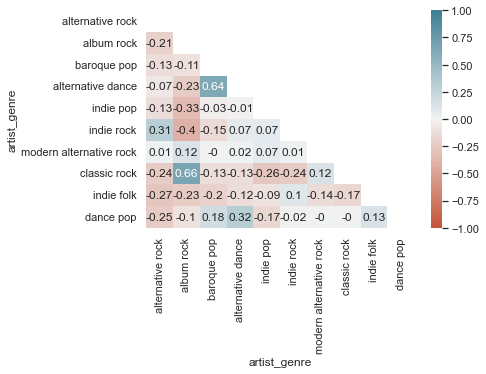

In [39]:
gen_corr = genre_count.iloc[:,0:11].corr().round(2)
mask = np.triu(np.ones_like(gen_corr, dtype=bool))
ax = sns.heatmap(
    gen_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    mask=mask,
    square=False
)